In [1]:
import os
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import urllib.request
from scipy.stats import spearmanr,pearsonr
import matplotlib.pyplot as plt
import cv2
import scipy
from skimage.measure import regionprops,label,regionprops_table
from skimage.filters import threshold_otsu
from skimage.morphology import (erosion, dilation, opening, closing,  # noqa
                                white_tophat)
from skimage.exposure import equalize_adapthist

from skimage.morphology import disk  # noqa
from scipy.spatial.distance import cdist

In [2]:
videoname='color preference - test'

In [3]:
vidcap = cv2.VideoCapture(videoname+'.mp4')
success,image = vidcap.read()

In [4]:
a=245
b=235
r=225

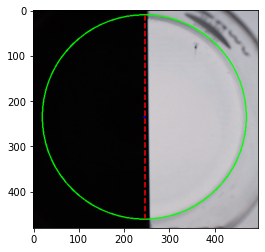

In [9]:
cv2.circle(image, (a, b), r, (0, 255, 0), 2)
cv2.circle(image, (a, b), 1, (0, 0, 255), 3)
plt.imshow(image)
plt.plot((a,a),(b-r,b+r),linestyle='--',c='r')


get location of first spot

In [10]:
# Convert to grayscale.
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Blur using 3 * 3 kernel.
gray_blurred = cv2.blur(gray, (3, 3))

        
#binarize
thresh = threshold_otsu(gray_blurred)
binary = gray_blurred >= thresh

In [11]:
tadpole_location=[]

tadpole_loc_img=binary[70:110,340:380]

labeled, nr_objects = scipy.ndimage.label(tadpole_loc_img ==0) 
print("Number of objects is {}".format(nr_objects))
props =regionprops(labeled)


###edge test
tadpole_location.append([70+props[0].centroid[1], 340+props[0].centroid[0]])

Number of objects is 1


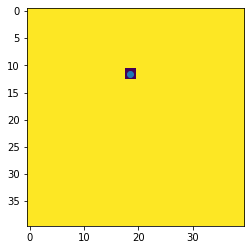

In [12]:
plt.imshow(tadpole_loc_img)
plt.scatter(props[0].centroid[1],props[0].centroid[0])

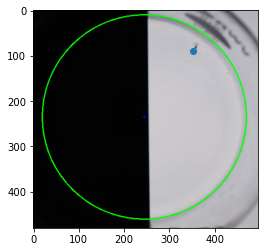

In [13]:
plt.imshow(image)
plt.scatter(tadpole_location[0][1],tadpole_location[0][0])

In [14]:
tadpole_location[0][1],tadpole_location[0][0]

(351.5, 88.5)

In [15]:
vidcap = cv2.VideoCapture(videoname+'.mp4')
success,image = vidcap.read()

thresh = threshold_otsu(gray)
binary = gray >= thresh


In [16]:
# initial
tadpole_location=[[87.75, 351.0]]
vidcap = cv2.VideoCapture(videoname+'.mp4')
success,image = vidcap.read()
count = 0
switch_or_not=1


In [17]:
# %%time
interval=25
# binary_before=labeled_before
while success:

    success,image = vidcap.read()
    count += 1
    if count>=1936 and count<=1977:
        continue
    if count ==1978:
        tadpole_location.append([331,238])
        continue
        
    if switch_or_not:
        if np.sum(image[100,400])<=140*3:
            tadpole_location.append([95,102])
            print(f'switch at count:{count}')
            switch_or_not=0
#         break
        
    if not success:
        break
    previous_tadpole_loc=tadpole_location[len(tadpole_location)-1]
    
    # Convert to grayscale.
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
    # Blur using 3 * 3 kernel.
    gray_blurred = cv2.blur(gray, (3, 3))
    
        
    #binarize
    if np.sum(image[100,400])>140*3:
        thresh = threshold_otsu(gray_blurred[:,260:])
    else:
        thresh = threshold_otsu(gray_blurred[:,:240])
    binary = gray >= thresh
#     if count==1:
#         1
#     else:
#         binary[binary==binary_before]=1
    
    tadpole_loc_img=binary[int(previous_tadpole_loc[0])-interval:int(previous_tadpole_loc[0])+interval,
                          int(previous_tadpole_loc[1])-interval:int(previous_tadpole_loc[1])+interval]
    labeled, nr_objects = scipy.ndimage.label(tadpole_loc_img ==0) 
#     print("Number of objects is {}".format(nr_objects))

    info_table = pd.DataFrame(
        regionprops_table(
            labeled,         properties=('label', 'centroid','area'),
        )
    ).set_index('label') 
    
    info_table=info_table.loc[info_table['area']<100,:]
    info_table=info_table.loc[info_table['area']>3,:]
    
    
    if info_table.shape[0]==0:
        dapi_coord = np.argwhere(labeled>0)
        if dapi_coord.shape[0]>0:

            relative_loc=dapi_coord[np.argmin(cdist(dapi_coord,np.array([interval,interval]).reshape(1,-1))),:]
            tadpole_location.append([int(previous_tadpole_loc[0])-interval+relative_loc[0],
                                    int(previous_tadpole_loc[1])-interval+relative_loc[1]])
        else:
            tadpole_location.append([int(previous_tadpole_loc[0]),
                                    int(previous_tadpole_loc[1])])
    else:
        if videoname=='edge preference_control' and (count>=3723 and count <=3744) or (count >=3842 and count <=3845):
            relative_loc=np.array(info_table.iloc[np.argmax(info_table['area'])][['centroid-0','centroid-1']])
        else:
            info_table=info_table.drop('area',axis=1)

            if np.min(cdist(np.array(info_table),np.array([interval,interval]).reshape(1,-1)))>10:
                print(f'error at {count}!')

                print("min dist is {}".format(np.min(cdist(np.array(info_table),np.array([interval,interval]).reshape(1,-1)))))

            relative_loc = np.array(info_table)[np.argmin(cdist(np.array(info_table),np.array([interval,interval]).reshape(1,-1))),:]
#         
        tadpole_location.append([int(previous_tadpole_loc[0])-interval+relative_loc[0],
                            int(previous_tadpole_loc[1])-interval+relative_loc[1]])
    
    if count ==2800:
        
        break

error at 1!
min dist is 10.182835023355219
switch at count:1219


In [18]:
vidcap = cv2.VideoCapture(videoname+'.mp4')
success,image = vidcap.read()

In [19]:
a,b,r

(245, 235, 225)

Text(0.5, 1.0, 'color preference - test')

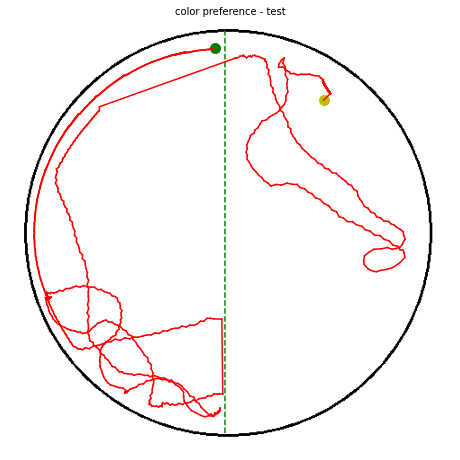

In [20]:
plt.figure(figsize=(8,8))

# image_b=np.zeros(image.shape)+255
image[:]=255
cv2.circle(image, (a, b), r, (0, 0, 0), 2)
plt.imshow(image)
plt.plot((a-3,a-3),(b-r,b+r),linestyle='--',c='g')
for i in range(0, len(tadpole_location)):
    plt.plot(np.array(tadpole_location)[i:i+2,1],np.array(tadpole_location)[i:i+2,0],c='r')
# plt.scatter(np.array(tadpole_location)[:,1],np.array(tadpole_location)[:,0],s=1,c='r')
plt.scatter(tadpole_location[0][1],tadpole_location[0][0],c='y',s=100)
plt.scatter(tadpole_location[len(tadpole_location)-1][1],tadpole_location[len(tadpole_location)-1][0],c='g',s=100)
plt.axis('off')
plt.title(videoname,fontsize=10)

In [21]:
video = cv2.VideoCapture(videoname+'.mp4');

(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

if int(major_ver)  < 3 :
    fps = video.get(cv2.cv.CV_CAP_PROP_FPS)
    print ("Frames per second uacsing video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
else :
    fps = video.get(cv2.CAP_PROP_FPS)
    print ("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))
video.release()


Frames per second using video.get(cv2.CAP_PROP_FPS) : 29.97002997002997


In [27]:
tadpole_location_smoothold=tadpole_location_smooth.copy()

In [49]:
tadpole_location_smooth=[tadpole_location_smoothold[i] for i in np.arange(0,len(tadpole_location_smoothold),3)]
tadpole_location=tadpole_location_smooth

In [65]:
from scipy.spatial import distance
speed_value=[]
for i in range(len(tadpole_location)-1):
    if i==645:
        print(tadpole_location[i],tadpole_location[i+1])
        speed_value.append( distance.euclidean(np.array(tadpole_location[i]), np.array(tadpole_location[i+1])) *6/r*10*fps/40)
    else:
        speed_value.append( distance.euclidean(np.array(tadpole_location[i]), np.array(tadpole_location[i+1])) *6/r*10*fps/3)
#         print( distance.euclidean(np.array(tadpole_location[i]), np.array(tadpole_location[i+1])) *6/r*10*fps/40)

[414, 235] [331, 238]


switch at 1218

In [66]:
maxspeed=147.24
for indi,i in enumerate(speed_value):
    if i>maxspeed:
        speed_value[indi]=maxspeed

In [67]:
cluster_pl=sns.color_palette("rainbow", 1001)

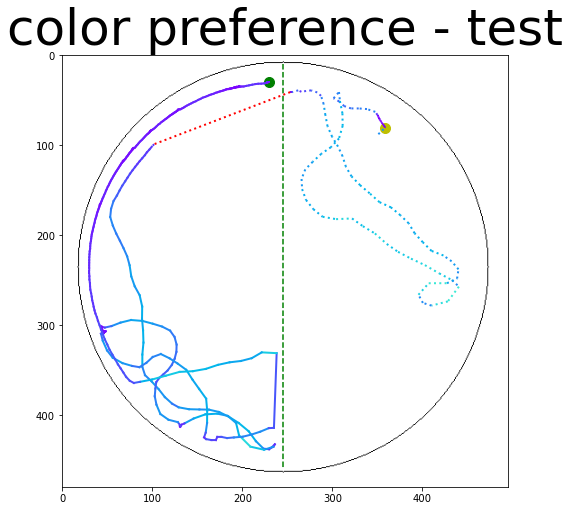

In [68]:
plt.figure(figsize=(8,8))
tadpole_location_smooth=tadpole_location
# image_b=np.zeros(image.shape)+255
image[:]=255
cv2.circle(image, (a, b), r+3, (0, 0, 0), 1)
plt.imshow(image)
plt.plot((a,a),(b-r,b+r),linestyle='--',c='g')
for i in range(0,408):
    plt.plot(np.array(tadpole_location_smooth)[i:i+2,1],np.array(tadpole_location_smooth)[i:i+2,0],':',
             color=list(cluster_pl[int(speed_value[i]/maxspeed*1000)]),linewidth=2)
    

for i in range(408, len(tadpole_location_smooth)-1):
    plt.plot(np.array(tadpole_location_smooth)[i:i+2,1],np.array(tadpole_location_smooth)[i:i+2,0],
            color=list(cluster_pl[int(speed_value[i]/maxspeed*1000)]),linewidth=2)

    # plt.scatter(np.array(tadpole_location_smooth)[:,1],np.array(tadpole_location_smooth)[:,0],s=10,c='r')

# plt.scatter(np.array(tadpole_location_smooth)[:,1],np.array(tadpole_location_smooth)[:,0],s=1,c='r')
plt.scatter(tadpole_location[1][1],tadpole_location[1][0],c='y',s=100)
plt.scatter(tadpole_location[len(tadpole_location)-1][1],tadpole_location[len(tadpole_location)-1][0],c='g',s=100)
# plt.axis('off')
plt.title(videoname,fontsize=50)

plt.savefig(f"{videoname}.pdf")
plt.show()

In [1]:
plt.figure(figsize=(8,8))
tadpole_location_smooth=tadpole_location
# image_b=np.zeros(image.shape)+255
image[:]=255
cv2.circle(image, (a, b), r+3, (0, 0, 0), 1)
plt.imshow(image)
plt.scatter(245,87)
plt.scatter(351,87)
plt.plot((a,a),(b-r,b+r),linestyle='--',c='g')

In [169]:
dis=[]
for i in range(len(tadpole_location_smooth)):

    dis.append(-tadpole_location_smooth[i][1]+245)
    if i==1936:
        for j in range(40):
            dis.append(0)

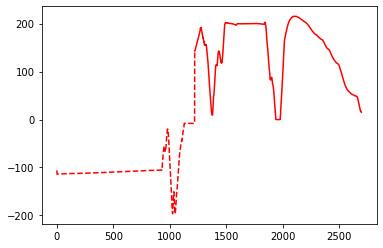

In [170]:
plt.plot(range(len(dis))[:1220],dis[:1220],'r--')
plt.plot(range(len(dis))[1219:],dis[1219:],'r')

In [173]:
o=pd.DataFrame(dis)

In [176]:
o.to_csv(videoname+'_dis.csv')